# Precip de-accumulation

## Load libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
import os

sys.path.append("../")
from QAQC_pipeline import *
import tempfile
import shutil

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def progressbar(it, prefix="", size=60, out=sys.stdout):  # Python3.6+
    """
    Print a progress bar to console

    References
    ----------
    https://stackoverflow.com/questions/3160699/python-progress-bar

    """
    count = len(it)
    start = time.time()  # time estimate start

    def show(j):
        x = int(size * j / count)
        # time estimate calculation and string
        remaining = ((time.time() - start) / j) * (count - j)
        mins, sec = divmod(remaining, 60)  # limited to minutes
        time_str = f"{int(mins):02}:{sec:03.1f}"
        print(
            f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count} Est wait {time_str}",
            end="\r",
            file=out,
            flush=True,
        )

    show(0.1)  # avoid div/0
    for i, item in enumerate(it):
        yield item
        show(i + 1)
    print("\n", flush=True, file=out)

In [3]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary
temp_dir = "./tmp"
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [4]:
zarr = False
files_df = read_network_files(network="ASOSAWOS", zarr=zarr)

In [5]:
files_df.head(3)

,era-id,network,rawdir,cleandir,qaqcdir,mergedir,key,exist
0,ASOSAWOS_72681024131,ASOSAWOS,1_raw_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/,3_qaqc_wx/ASOSAWOS/,4_merge_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/ASOSAWOS_72681024131.nc,True
1,ASOSAWOS_72774024135,ASOSAWOS,1_raw_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/,3_qaqc_wx/ASOSAWOS/,4_merge_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/ASOSAWOS_72774024135.nc,True
2,ASOSAWOS_72571094025,ASOSAWOS,1_raw_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/,3_qaqc_wx/ASOSAWOS/,4_merge_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/ASOSAWOS_72571094025.nc,True


In [6]:
nSample = 1
# files_df_sample = files_df.loc[int(len(files_df)/3/4), :]
# station = files_df_sample['era-id']
files_df_sample = files_df.sample(nSample)
station = files_df_sample["era-id"].iloc[0]
station

'ASOSAWOS_72462023061'

In [7]:
file_name = files_df.loc[files_df["era-id"] == station, "key"].values[0]
qaqcdir = files_df.loc[files_df["era-id"] == station, "qaqcdir"].values[0]
network_ds = files_df.loc[files_df["era-id"] == station, "network"].values[0]

In [8]:
def read_nc_from_s3(file_name, station):

    fs = s3fs.S3FileSystem()
    aws_url = "s3://wecc-historical-wx/" + file_name
    t0 = time.time()
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            ds = xr.open_dataset("../Train_Files/{}.nc".format(station)).load()
    except:
        # Create a temporary file
        with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as temp_file:
            # Download the file from S3
            s3_cl.download_file("wecc-historical-wx", file_name, temp_file.name)
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=RuntimeWarning)
                # Read the NetCDF file using xarray
                ds = xr.open_dataset(temp_file.name).load()

            # Save temp file
            os.rename(temp_file.name, f"../Train_Files/{station}.nc")

    return ds

In [9]:
ds = read_nc_from_s3(file_name, station)

In [10]:
df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(ds, verbose=False)

In [11]:
df.head(3)

,time,ps,tas,tdps,pr,sfcWind,sfcWind_dir,elevation,qaqc_process,ps_qc,...,ps_altimeter_eraqc,psl_eraqc,anemometer_height_m,thermometer_height_m,station,hour,day,month,year,date
0,1980-01-01 00:00:00,77620.0,258.75,254.25,0.0,3.6,340.0,2297.0,V020,5,...,NaN,NaN,10.06,NaN,ASOSAWOS_72462023061,0,1,1,1980,1980-01-01
1,1980-01-01 01:00:00,NaN,256.05,253.85,0.0,2.0,330.0,2297.0,V020,9,...,NaN,NaN,10.06,NaN,ASOSAWOS_72462023061,1,1,1,1980,1980-01-01
2,1980-01-01 02:00:00,NaN,252.65,250.45,0.0,3.0,300.0,2297.0,V020,9,...,NaN,NaN,10.06,NaN,ASOSAWOS_72462023061,2,1,1,1980,1980-01-01


In [12]:
def count_increases_decreases(column):

    # Compute differences between consecutive values
    diffs = column.diff()

    # Count increasing and decreasing occurrences
    num_increases = (diffs > 0).sum()
    num_decreases = (diffs < 0).sum()

    print(num_increases, num_decreases)

In [13]:
def read_testing_file(network, station=None):
    zarr = False

    if station is None:
        files_df = read_network_files(network=network, zarr=zarr)
        nSample = 1
        files_df_sample = files_df.sample(nSample)
        station = files_df_sample["era-id"].iloc[0]

    else:
        network = station.split("_")[0]
        files_df = read_network_files(network=network, zarr=zarr)

    file_name = files_df.loc[files_df["era-id"] == station, "key"].values[0]
    qaqcdir = files_df.loc[files_df["era-id"] == station, "qaqcdir"].values[0]
    network_ds = files_df.loc[files_df["era-id"] == station, "network"].values[0]

    ds = read_nc_from_s3(file_name, station)

    df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(ds, verbose=False)

    return ds, df, MultiIndex, attrs, var_attrs, era_qc_vars

In [14]:
ds_s, df_s, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
    network="ASOSAWOS"
)
ds_s = ds_s.squeeze()

In [15]:
_ = df_s.groupby("year")["pr"].apply(count_increases_decreases)

4 6


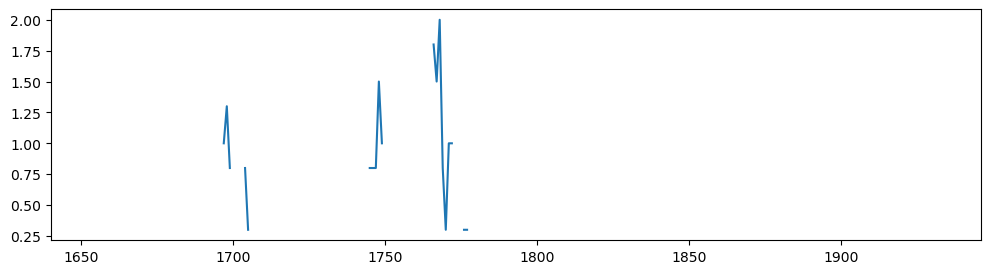

In [16]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df_s.pr)

In [17]:
ds_c, df_c, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
    network="RAWS"
)
# ds_c, df_c, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(network="RAWS", station="RAWS_TT046")
ds_c = ds_c.squeeze()

In [18]:
_ = df_c.groupby("year")["pr"].apply(count_increases_decreases)

205 0
97 0
0 0
16 1
41 1
0 0


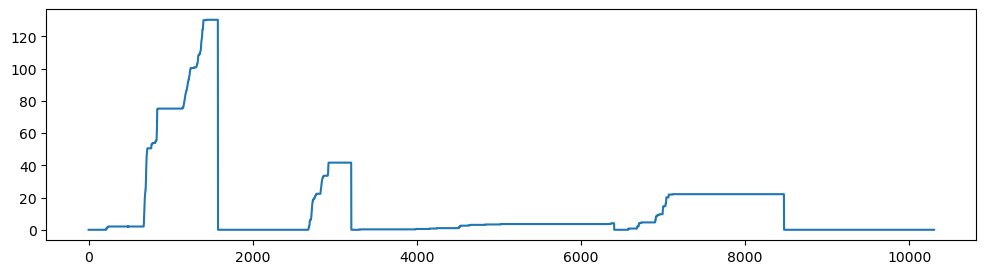

In [19]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df_c.pr)

In [20]:
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler


def normalize_series(series):
    """
    Normalizes a Pandas Series between 0 and 1.
    """
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(series.values.reshape(-1, 1))
    return pd.Series(normalized.flatten(), index=series.index)


def measure_difference(original_series):
    """
    Measures how different a randomly shuffled version of a time series is
    compared to the original using statistical and autocorrelation metrics.

    Parameters:
    - original_series: Pandas Series (time series)

    Returns:
    - Dictionary with similarity metrics.
    """
    # Drop NaNs and normalize the data
    original_series = original_series.dropna()
    normalized_series = normalize_series(original_series)

    # Create a shuffled version
    shuffled_series = np.random.permutation(normalized_series)

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(shuffled_series, lw=0.25)
    ax.plot(normalized_series, lw=2)

    print(len(original_series), len(shuffled_series), len(normalized_series))

    # Kolmogorov-Smirnov Test (distribution difference)
    ks_stat, ks_pvalue = ks_2samp(normalized_series, shuffled_series)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(normalized_series - shuffled_series))

    # Autocorrelation difference (how much order affects correlation)
    original_autocorr = normalized_series.autocorr()
    shuffled_autocorr = pd.Series(shuffled_series).autocorr()
    autocorr_loss = abs(original_autocorr - shuffled_autocorr)

    return {
        "KS Statistic": ks_stat,
        "KS p-value": ks_pvalue,
        "Mean Absolute Error": mae,
        "Autocorrelation Loss": autocorr_loss,
    }

6882 6882 6882


,KS Statistic,KS p-value,Mean Absolute Error,Autocorrelation Loss
0,0.0,1.0,0.208606,0.980556


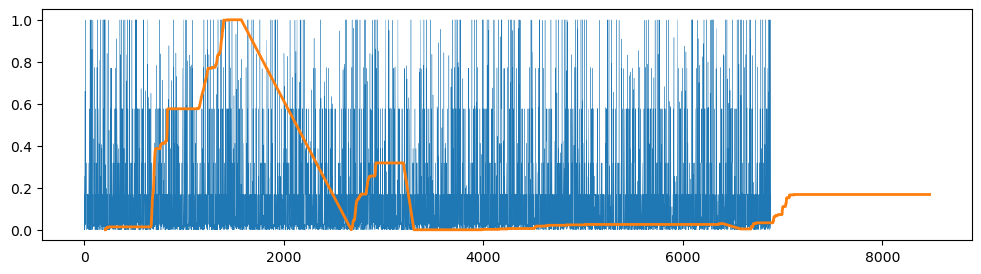

In [21]:
# Example usage
original_series = df_c["pr"][df_c["pr"] > 0]  # Replace with your series
diff_metrics = measure_difference(original_series)

# Convert results to DataFrame and display
results_df = pd.DataFrame([diff_metrics])
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Difference Metrics", dataframe=results_df)
results_df

In [22]:
df_s["pr"].autocorr()

0.4324785539143404

In [23]:
df_s["pr"][df_s["pr"] > 0].autocorr()

0.30586699403469036

In [24]:
df_c["pr"].autocorr()

0.998646348562471

In [25]:
df_c["pr"][df_c["pr"] > 0].autocorr()

0.9984935442007705

In [26]:
for l in range(1, 100):
    print(df_c["pr"][df_c["pr"] > 0].autocorr(lag=l))

0.9984935442007705
0.9969702246208333
0.9954250518574072
0.9938660528562192
0.9922946273475403
0.9907129388694854
0.9891229860555951
0.9875260044536639
0.9859182018367345
0.9843000106513988
0.9826718973258234
0.9810340126984891
0.9793927495977025
0.9777483447066104
0.9761062902161632
0.9744769223543257
0.9728498542614702
0.9712304038495058
0.9696080286617136
0.9679820481975084
0.9663474943351753
0.9647047682834909
0.9630540548450226
0.9614008471870777
0.9597395900347807
0.9580708716101669
0.9563949077372916
0.9547125777830123
0.9530244569494611
0.9513362353775704
0.9496427480078943
0.9479499533777301
0.9462529748944081
0.9445573590897276
0.9428632606918186
0.9411760517010691
0.9394961760060603
0.9378288516900366
0.9361743684454752
0.9345276538170828
0.9328889249454834
0.931263142714803
0.9296507000095289
0.9280518556880296
0.9264616501262978
0.9248854367082864
0.9233181214976737
0.9217650169306517
0.9202207503288138
0.9186800103262044
0.9171475832946048
0.9156182606935785
0.91409244504

In [27]:
for l in range(1, 100):
    print(df_c["pr"].autocorr(lag=l))

0.998646348562471
0.9972687898365519
0.9958721708268431
0.9944588965924367
0.9930301871060359
0.9915879000405308
0.9901338034527423
0.98866897408373
0.9871947132985895
0.9857113077536537
0.9842192506991227
0.9827186133120526
0.981210418821077
0.9796948732154931
0.9781721555590492
0.9766420586973438
0.9751047437356544
0.9735602370549999
0.9720085650388292
0.9704491342367334
0.9688822225243532
0.9673081796737345
0.9657271668318755
0.9641393631298415
0.9625444535819399
0.9609430306042062
0.95933528235984
0.9577218822178201
0.9561034227482902
0.9544802539752453
0.95285248334598
0.9512207215261262
0.9495853006744036
0.947946445147278
0.9463042894584384
0.9446589052277357
0.943010678626634
0.9413595465049006
0.9397057602661985
0.9380495084258381
0.9363909795181115
0.9347298857258957
0.933066568387222
0.9314012520231127
0.929734224098829
0.9280655383938952
0.926395365553556
0.9247237234190402
0.9230505399361787
0.921375823952948
0.9196991078392269
0.9180204633412153
0.9163402409216483
0.91465

In [28]:
%%time
for l in range(1, 100):
    print(df_s["pr"][df_s["pr"] > 0].autocorr(lag=l))

0.30586699403469036
-0.14076812524408303
-0.17741285335529589
-0.06095404939142882
0.10453024649845225
0.1268352068824839
-0.3058255523835507
-0.3400045914058443
0.0006249993896493183
-0.3785401998821647
-0.23388525825634746
0.10659417826776338
0.11668465224705069
0.051355464638680036
0.14892084929531757
-0.3367468767462423
0.2890120245085989
0.8608981196046079
-0.29720060876003435
-0.5493991853679282
0.7921180343813397
0.14285714285714282
-1.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
CPU times: user 13.5 ms, sys: 1.55 ms, total: 15.1 ms
Wall time: 14.6 ms


/Users/hector/miniconda3/envs/hist-obs/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/hector/miniconda3/envs/hist-obs/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [29]:
for l in range(1, 100):
    print(df_s["pr"].autocorr(lag=l))

0.4324785539143404
0.0373976861671988
-0.09557876194600114
0.3919788215975111
0.7242017863998604
0.6940531078214707
0.24525573579398624
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.3273268353539886
0.9807375013075875
0.6521405955174383
0.5556913832497041
-0.29729251925401107
-0.10199801195062418
0.3209541378542161
0.4539899450747865
0.5773502691896257
1.0
-0.9999999999999998
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-0.9367659069225726
0.702068806114664
1.0
0.8029550685469662
-0.20493813410363274
-0.7921180343813394
0.3858441116174885
0.722887564134312
0.6910032486238308
0.49999999999999983
-0.6546536707079771
nan
nan
nan
nan
nan
nan
nan
-0.9999999999999998
-0.7961692986474497
-1.0
1.0
0.21677749238103003
-0.6702082814407996
0.15523010514126656
0.8900024213633337
0.5980586126161953
0.8654134840580876
0.39600421851889955
0.10604209765692461
0.3665083330689157
nan
0.8461538461538461
nan
nan
-0.8660254037844386
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

In [67]:
def is_precip_accumulated(pr):
    """
    Determines whether a precipitation time series is likely accumulated based on its autocorrelation.

    Parameters
    ----------
    pr : pandas.Series
        A time series of precipitation values, which may contain missing (NaN) values.

    Returns
    -------
    bool
        `True` if the mean autocorrelation exceeds 0.9, suggesting that the precipitation data is accumulated.
        `False` otherwise.

    Notes
    -----
    - The function filters out non-positive and missing values before computing autocorrelation.
    - If the filtered series has more than 100 values, autocorrelation is computed for lags up to 50.
    - Otherwise, it is computed for lags up to half the length of the filtered series.
    - High autocorrelation (above 0.9) suggests that the data may represent accumulated precipitation over time.

    Examples
    --------
    >>>
    >>>
    >>>
    >>>
    """

    test_pr = pr[(pr > 0) & (~pr.isnull())]
    if len(test_pr) > 100:
        autocorr = [test_pr.autocorr(lag=l) for l in range(50)]
    else:
        autocorr = [test_pr.autocorr(lag=l) for l in range(int(len(test_pr) / 2))]

    if np.nanmean(autocorr) > 0.9:
        return True
    else:
        return False

In [31]:
is_precip_accumulated(df_c["pr"])

True

In [32]:
is_precip_accumulated(df_s["pr"])

False

In [33]:
import glob

In [34]:
test_files = [
    fName.split("/")[-1].split(".nc")[0] for fName in glob.glob("../Train_Files/RAWS*")
]

In [35]:
for test in test_files:
    ds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
        network="RAWS", station=test
    )
    print(is_precip_accumulated(df["pr"]))
    del (ds, df, MultiIndex, attrs, var_attrs, era_qc_vars)

True
True
True
True
True
True
True
True
True
True
True


In [36]:
test_files = [
    fName.split("/")[-1].split(".nc")[0]
    for fName in glob.glob("../Train_Files/ASOSAWOS*")
][:10]

In [37]:
for test in test_files:
    ds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
        network="ASOSAWOS", station=test
    )
    try:
        print(is_precip_accumulated(df["pr"]))
        del (ds, df, MultiIndex, attrs, var_attrs, era_qc_vars)
    except:
        pass

False
False
False
False
False
False
False
False
False
False


In [78]:
import pandas as pd
import numpy as np


def de_accumulate(series, reset_threshold=None):
    """
    Converts an accumulated time series into incremental values by computing differences.
    Handles cases where accumulation resets to zero.

    Parameters
    ----------
    series : pandas.Series
        The accumulated time series (e.g., precipitation, energy usage).
    reset_threshold : float, optional
        The threshold to detect a reset (if None, assumes any drop to zero is a reset).

    Returns
    -------
    pandas.Series
        The de-accumulated (incremental) series.

    Notes
    -----
    - If `reset_threshold` is provided, it is used to detect unnatural drops (e.g., if accumulation should never decrease by more than this value).
    - If the threshold is not set, any drop to zero is considered a reset.
    - Negative increments (except resets) are set to zero under the assumption that values should not decrease naturally.
    """
    diff_series = series.diff()

    # First check (to see if there is any ringing/up-down measurements, only take the highest

    if reset_threshold is not None:
        resets = diff_series < -reset_threshold  # Detect large drops
    else:
        resets = (series.diff() < 0) & (series.shift(-1) == 0)  # Drop to zero
    print(resets.any())
    diff_series[resets] = np.nan  # Mark reset points
    diff_series.fillna(
        0, inplace=True
    )  # Replace NaNs with zero (or use interpolation if needed)

    return diff_series, resets

In [68]:
ds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
    network="ASOSAWOS"
)

<AxesSubplot:>

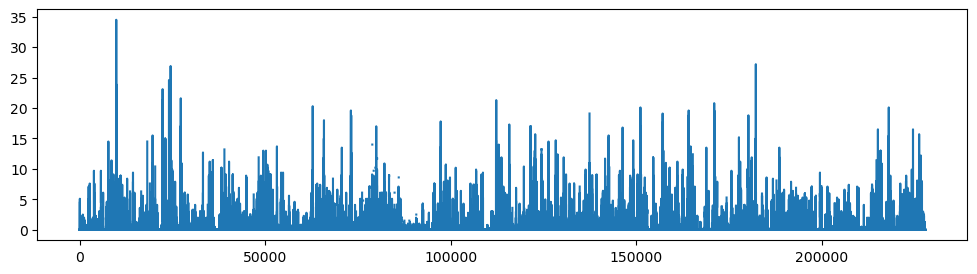

In [69]:
fig, ax = plt.subplots(figsize=(12, 3))
df.pr.plot()

In [70]:
ds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(network="RAWS")

In [82]:
pr, resets = de_accumulate(df.pr)

True


In [ ]:
# df.stationds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(network="RAWS")

In [217]:
ds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
    network="RAWS", station="RAWS_ERCC1"
)

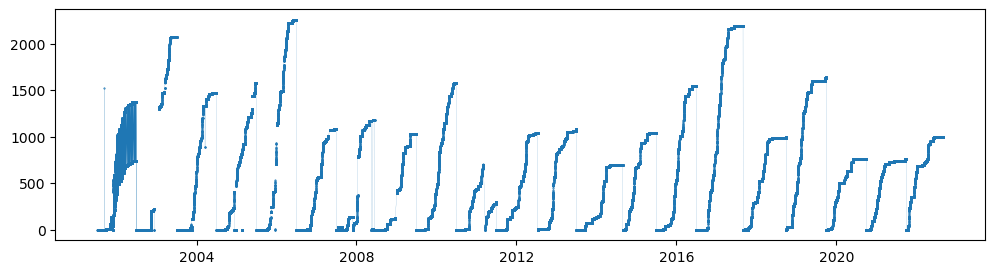

In [211]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.time, df.pr, marker=".", markersize=1, lw=0.1, mfc="none")
# ax.plot(df.time,pr)
# ax.plot(df.time[resets],pr[resets], marker="o", lw=0, mfc='none')
# ax.set_xlim(np.datetime64("2001-06-01"),np.datetime64("2003-01-01"))

(17897.0, 18567.0)

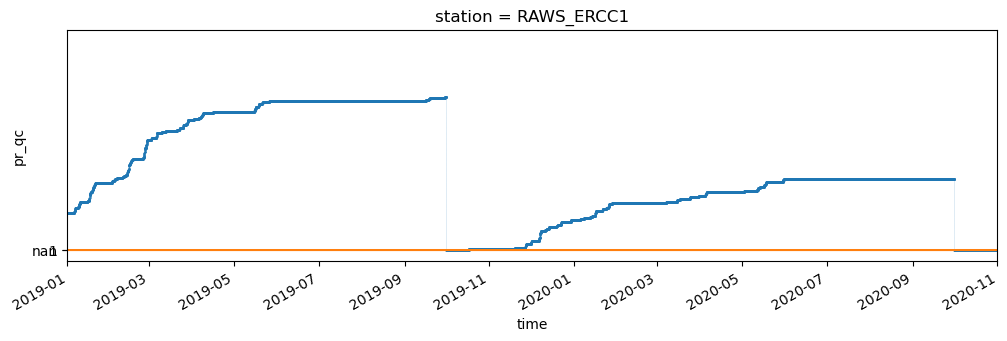

In [109]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.time, df.pr, marker=".", markersize=1, lw=0.1, mfc="none")
# ax.plot(df.time,pr)
# ax.plot(df.time[resets],pr[resets], marker="o", lw=0, mfc='none')
ds.pr_qc.plot(ax=ax)

ax.set_xlim(np.datetime64("2019-01-01"), np.datetime64("2020-11-01"))

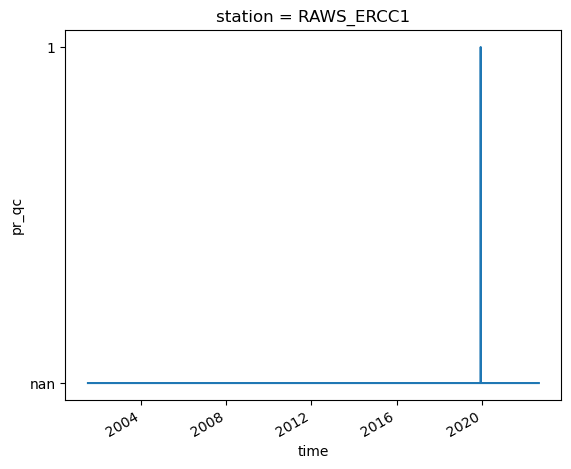

In [104]:
ds.pr_qc.plot()

(11474.0, 12053.0)

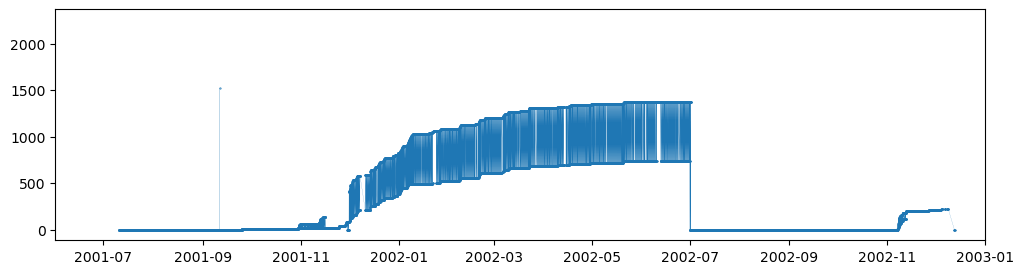

In [92]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.time, df.pr, marker=".", markersize=1, lw=0.1, mfc="none")
# ax.plot(df.time,pr)
# ax.plot(df.time[resets],pr[resets], marker="o", lw=0, mfc='none')
ax.set_xlim(np.datetime64("2001-06-01"), np.datetime64("2003-01-01"))

(11474.0, 12053.0)

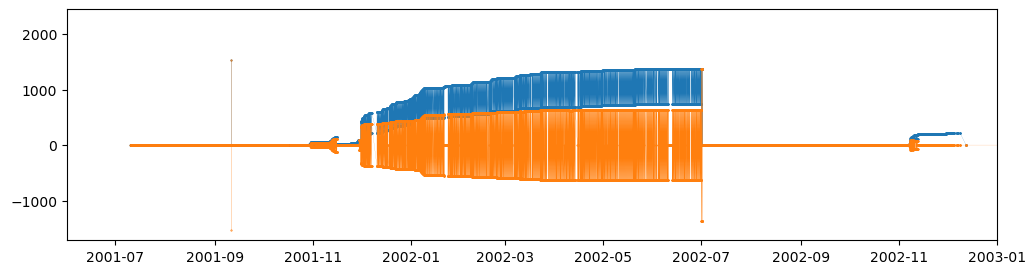

In [94]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.time, df.pr, marker=".", markersize=1, lw=0.1, mfc="none")
ax.plot(df.time, pr, marker=".", markersize=1, lw=0.1, mfc="none")
# ax.plot(df.time[resets],pr[resets], marker="o", lw=0, mfc='none')
ax.set_xlim(np.datetime64("2001-06-01"), np.datetime64("2003-01-01"))

(11474.0, 12053.0)

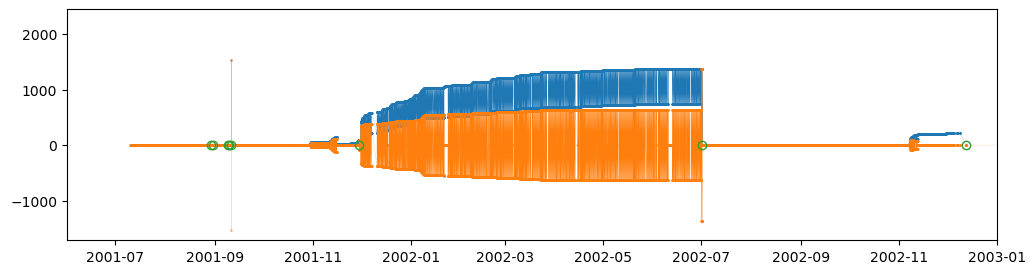

In [95]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.time, df.pr, marker=".", markersize=1, lw=0.1, mfc="none")
ax.plot(df.time, pr, marker=".", markersize=1, lw=0.1, mfc="none")
ax.plot(df.time[resets], pr[resets], marker="o", lw=0, mfc="none")
ax.set_xlim(np.datetime64("2001-06-01"), np.datetime64("2003-01-01"))

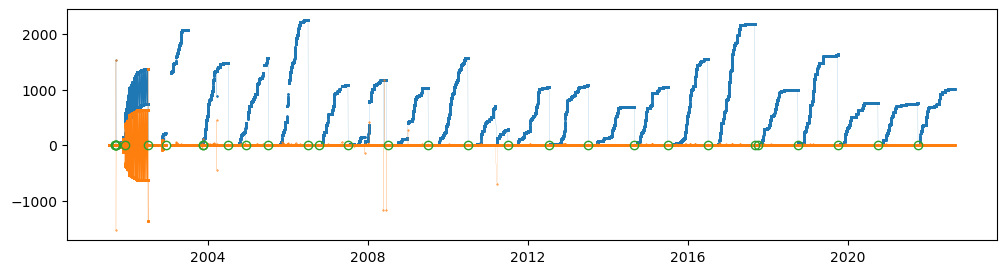

In [110]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.time, df.pr, marker=".", markersize=1, lw=0.1, mfc="none")
ax.plot(df.time, pr, marker=".", markersize=1, lw=0.1, mfc="none")
ax.plot(df.time[resets], pr[resets], marker="o", lw=0, mfc="none")
# ax.set_xlim(np.datetime64("2001-06-01"),np.datetime64("2003-01-01"))

(-300.0, 300.0)

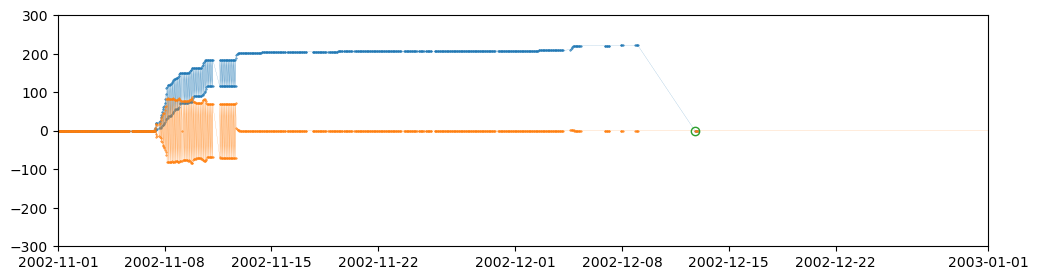

In [98]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.time, df.pr, marker=".", markersize=1, lw=0.1, mfc="none")
ax.plot(df.time, pr, marker=".", markersize=1, lw=0.1, mfc="none")
ax.plot(df.time[resets], pr[resets], marker="o", lw=0, mfc="none")
ax.set_xlim(np.datetime64("2002-11-01"), np.datetime64("2003-01-01"))
ax.set_ylim(-300, 300)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.time, df.pr, marker=".", markersize=1, lw=0.1, mfc="none")
ax.plot(df.time, pr, marker=".", markersize=1, lw=0.1, mfc="none")
ax.plot(df.time[resets], pr[resets], marker="o", lw=0, mfc="none")
ax.set_xlim(np.datetime64("2001-06-01"), np.datetime64("2003-01-01"))

In [101]:
df.station

0         RAWS_ERCC1
1         RAWS_ERCC1
2         RAWS_ERCC1
3         RAWS_ERCC1
4         RAWS_ERCC1
             ...    
189628    RAWS_ERCC1
189629    RAWS_ERCC1
189630    RAWS_ERCC1
189631    RAWS_ERCC1
189632    RAWS_ERCC1
Name: station, Length: 189633, dtype: object

In [160]:
import pandas as pd
import numpy as np

In [161]:
flag = flag_ringing(df.pr.diff(), window=2, threshold=150)

<AxesSubplot:xlabel='time'>

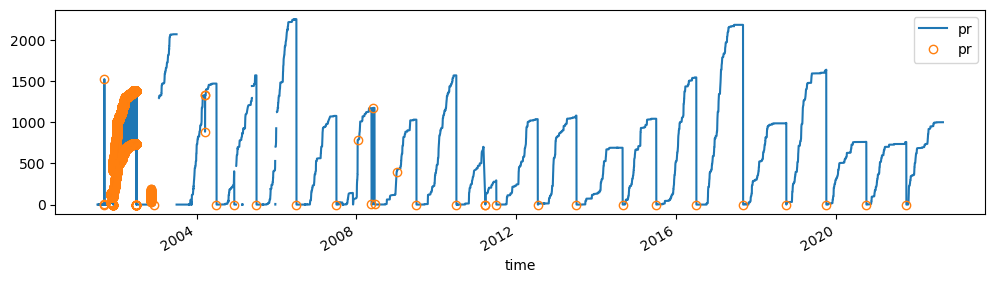

In [162]:
fig, ax = plt.subplots(figsize=(12, 3))
df.plot(ax=ax, x="time", y="pr")
df[flag].plot(ax=ax, marker="o", lw=0, mfc="none", x="time", y="pr")

(11566.0, 11627.0)

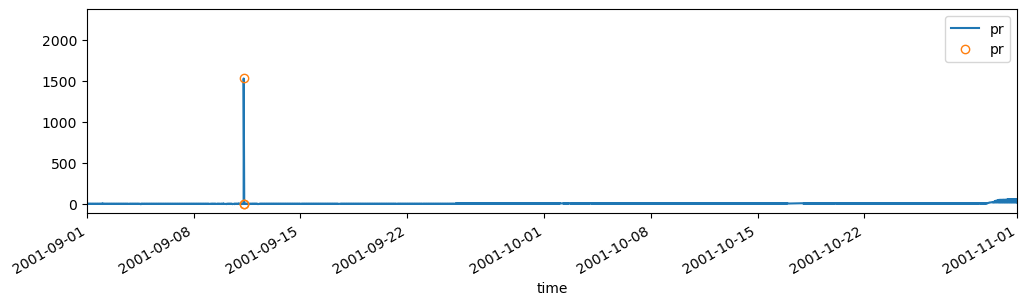

In [163]:
fig, ax = plt.subplots(figsize=(12, 3))
df.plot(ax=ax, x="time", y="pr")
df[flag].plot(ax=ax, marker="o", lw=0, mfc="none", x="time", y="pr")
ax.set_xlim(np.datetime64("2001-09-01"), np.datetime64("2001-11-01"))

(11620.0, 11883.0)

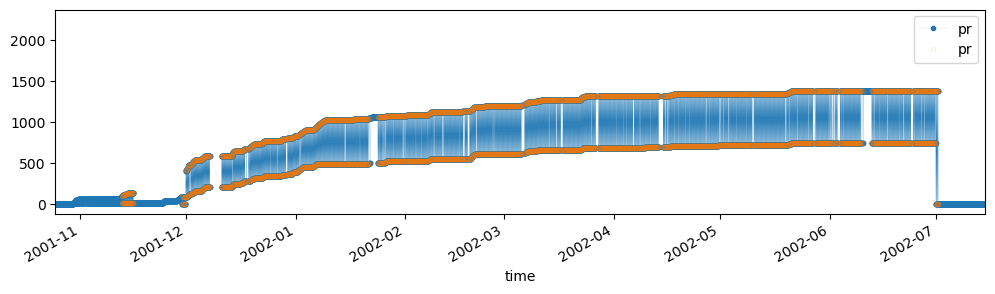

In [164]:
fig, ax = plt.subplots(figsize=(12, 3))
df.plot(ax=ax, x="time", y="pr", marker=".", lw=0.05)
df[flag].plot(ax=ax, marker=".", lw=0, mfc="none", x="time", y="pr", alpha=0.10)
ax.set_xlim(np.datetime64("2001-10-25"), np.datetime64("2002-07-15"))

(-300.0, 300.0)

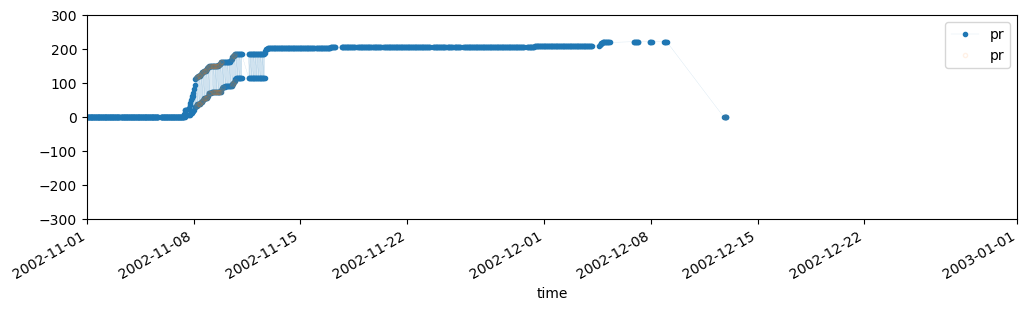

In [165]:
fig, ax = plt.subplots(figsize=(12, 3))
df.plot(ax=ax, x="time", y="pr", marker=".", lw=0.05)
df[flag].plot(ax=ax, marker=".", lw=0, mfc="none", x="time", y="pr", alpha=0.10)
ax.set_xlim(np.datetime64("2002-11-01"), np.datetime64("2003-01-01"))
ax.set_ylim(-300, 300)

(-20.0, 25.0)

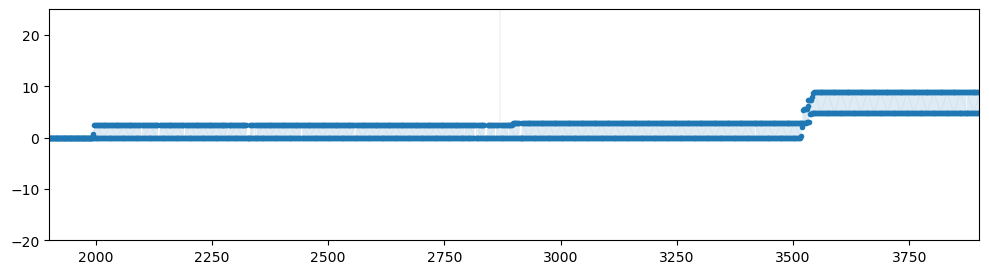

In [453]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.pr, marker=".", lw=0.05)
ax.set_xlim(1900, 3900)
ax.set_ylim(-20, 25)

<AxesSubplot:>

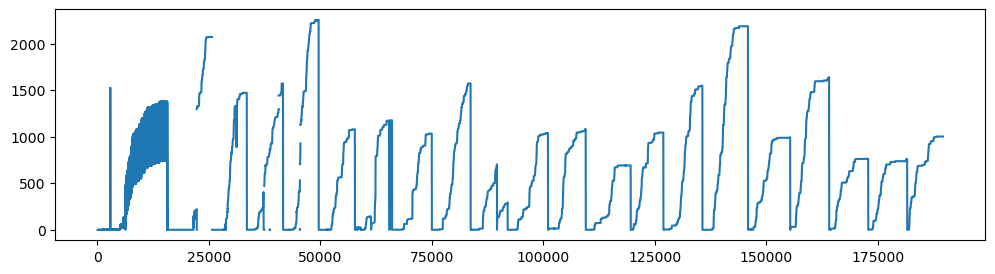

In [218]:
fig, ax = plt.subplots(figsize=(12, 3))
df.pr.plot(ax=ax)

In [219]:
def is_precip_accumulated(pr):
    """
    Determines whether a precipitation time series is accumulated by analyzing its autocorrelation.

    Parameters
    ----------
    pr : pandas.Series
        A time series of precipitation values, which may contain missing (NaN) values.

    Returns
    -------
    bool
        `True` if the mean autocorrelation of the filtered series is greater than 0.9, indicating
        that the precipitation data is likely accumulated.
        `False` otherwise.

    Notes
    -----
    - The function filters out non-positive and missing values from `pr` before computing autocorrelation.
    - The Pearson autocorrelation is computed using `pandas.Series.autocorr()`, which measures the
      correlation of the series with a lag of 1.
    - If the mean autocorrelation exceeds 0.9, the function assumes that the data is accumulated precipitation.
    - Missing values (`NaN`) in the autocorrelation calculation are handled using `np.nanmean()`
      to avoid bias in the decision.

    Examples
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> pr = pd.Series([0, 0, 5, 10, 15, 20, np.nan, 25, 30, 35])
    >>> is_precip_accumulated(pr)
    True
    """
    test_pr = pr[(pr > 0) & (~pr.isnull())]
    autocorr = test_pr.autocorr()
    if np.nanmean(autocorr) > 0.9:
        return True
    else:
        return False

In [220]:
def flag_ringing(series, window=3, threshold=None):
    """
    Flags values exhibiting ringing (back-and-forth oscillations).

    Parameters
    ----------
    series : pandas.Series
        The input time series.
    window : int, optional
        The window size for detecting frequent oscillations (default is 3).
    threshold : float, optional
        A custom threshold for detecting large fluctuations (default is automatic detection).

    Returns
    -------
    pandas.Series
        A boolean series where `True` indicates a flagged (bad) ringing value.
    """
    diff_series = series.diff()  # Compute first difference
    sign_changes = np.sign(diff_series).diff().fillna(0).abs()  # Detect sign changes

    # Rolling sum of sign changes (to detect frequent oscillations in a window)
    ringing_flags = sign_changes.rolling(window=window, center=True).sum() > (
        window - 1
    )

    # Optional threshold for large alternating fluctuations
    if threshold is None:
        threshold = (
            diff_series.abs().median() * 2
        )  # Use 2x median difference as default threshold

    large_fluctuations = diff_series.abs() > threshold
    ringing_flags = (
        ringing_flags & large_fluctuations
    )  # Flag only if oscillations are significant

    return ringing_flags

In [479]:
def de_accumulate(original_series, reset_threshold=None, window=3, threshold=None):
    """
    Converts an accumulated time series into incremental values by computing differences.
    Handles cases where accumulation resets to zero and filters out ringing values.

    Parameters
    ----------
    original_series : pandas.Series
        The accumulated time series (e.g., precipitation, energy usage).
        It should have a numeric index representing time or sequence.
    reset_threshold : float, optional
        The threshold to detect a reset. If None (default), any drop to zero is considered a reset.
        If provided, resets are detected when the difference is less than `-reset_threshold`.
    window : int, optional
        The window size used for detecting ringing (default is 3).
    threshold : float, optional
        The threshold for detecting ringing behavior. If None, it will be determined automatically.

    Returns
    -------
    pandas.Series
        The de-accumulated (incremental) time series with ringing values removed and resets handled.

    Notes
    -----
    - The function first computes the first difference (`diff()`) of the series.
    - It applies `flag_ringing()` to identify oscillatory (ringing) values and removes them.
    - Any negative differences (except resets) are set to zero under the assumption that the accumulation should not decrease naturally.
    - If `reset_threshold` is provided, it is used to detect unnatural drops (e.g., if accumulation should never decrease by more than this value).
    - If the threshold is not set, any drop to zero is considered a reset.
    - The cleaned differences are returned, ensuring that resets are handled properly.

    Examples
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> series = pd.Series([0, 5, 10, 20, 0, 3, 7, 15, 25, 0, 4, 9],
    ...                   index=pd.date_range("2024-01-01", periods=12, freq="D"))
    >>> de_accumulate(series, reset_threshold=15)
    2024-01-01     NaN
    2024-01-02     5.0
    2024-01-03     5.0
    2024-01-04    10.0
    2024-01-05     0.0
    2024-01-06     3.0
    2024-01-07     4.0
    2024-01-08     8.0
    2024-01-09    10.0
    2024-01-10     0.0
    2024-01-11     4.0
    2024-01-12     5.0
    dtype: float64

    """
    series = original_series.copy()
    diff_series = series.copy().diff()

    # First check (to see if there is any ringing/up-down measurements, only take the highest
    flags = flag_ringing(diff_series, window=window, threshold=threshold)
    diff_series2 = diff_series.copy().loc[flags[~flags].index].dropna()

    # Only take difference values higher than zero
    flags2 = diff_series2 < 0

    # Merge together >0 flags and original flags
    flags = pd.concat([flags, flags2], axis=1)

    # Rename columns (optional)
    flags.columns = ["flags1", "flags2"]

    # Apply OR operation (handling NaNs as False)
    flags = flags.fillna(False)["flags1"] | flags.fillna(False)["flags2"]

    # Fix the flags where original series is zero
    flags[series == 0] = False

    # De-accumulate clean series (without ringing)
    clean_series = series.copy().loc[~flags]
    clean_diff_series = clean_series.diff()

    if reset_threshold is not None:
        resets = clean_diff_series < -reset_threshold  # Detect large drops
    else:
        resets = (clean_series.diff() < 0) & (
            clean_series.shift(-1) == 0
        )  # Drop to zero

    clean_diff_series[resets] = np.nan  # Mark reset points
    clean_diff_series.fillna(
        0, inplace=True
    )  # Replace NaNs with zero (or use interpolation if needed)

    # Re-flag negative differences
    flags2 = clean_diff_series < 0

    # Merge together >0 flags and original flags
    flags = pd.concat([flags, flags2], axis=1)

    # Rename columns (optional)
    flags.columns = ["flags1", "flags2"]

    # Apply OR operation (handling NaNs as False)
    flags = flags.fillna(False)["flags1"] | flags.fillna(False)["flags2"]

    # Return the complete difference series
    diff_series = original_series.copy().diff() * np.nan
    diff_series.loc[~flags] = clean_diff_series

    return diff_series, flags

In [483]:
pr, flags = de_accumulate(df.pr, reset_threshold=50, threshold=10, window=3)
len(df.pr), len(pr)

(189633, 189633)

In [487]:
def qaqc_deaccumulate_precip(df, var="pr"):

    vars_for_deacummulation = ["pr"]

    vars_to_check = [var for var in df.columns if var in vars_for_deacummulation]

    try:
        logger.info(
            "Running {} on {}".format("qaqc_deaccumulate_precip", vars_to_check),
        )
        # First, determine if the series is accumulated or instantaneous
        if is_precip_accumulated(df[var]) and len(vars_to_check) > 0:

            # Calculate de-accumulated precip and flag "ringing" values
            diff_series, flags = de_accumulate(
                df[var], reset_threshold=50, window=3, threshold=10
            )
            df.loc[flags, var + "_eraqc"] = 34  # see era_qaqc_flag_meanings.csv

            # Save original accumulated precip into new variable, and de-accumulated into original pr
            # and save de-accumulated precip into original pr
            tmp_var, tmp_index = df[var].values, df[var].index
            df[var] = diff_series.values
            df["accum_" + var] = tmp_var

            # Flag the new accum_pr to acknowledge that precip was de-accumulated
            df.loc[:, "accum_" + var + "_eraqc"] = 35  # see era_qaqc_flag_meanings.csv

            logger.info("qaqc_deaccumulate_precip bypassed: Precip is not accumulated")

        else:  # If it's not accumulated, bypass and return original df
            logger.info(
                "{} on {} done".format("qaqc_deaccumulate_precip", vars_to_check),
            )
            return df

    except Exception as e:
        logger.info(
            "qaqc_deaccumulate_precip failed with Exception: {}".format(e),
        )
        return None

    return

In [6]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
import os

sys.path.append("../")
from QAQC_pipeline import *
import tempfile
import shutil

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary
temp_dir = "./tmp"
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [8]:
zarr = False
files_df = read_network_files(network="ASOSAWOS", zarr=zarr)

In [9]:
files_df.head(3)

,era-id,network,rawdir,cleandir,qaqcdir,mergedir,key,exist
0,ASOSAWOS_72681024131,ASOSAWOS,1_raw_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/,3_qaqc_wx/ASOSAWOS/,4_merge_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/ASOSAWOS_72681024131.nc,True
1,ASOSAWOS_72774024135,ASOSAWOS,1_raw_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/,3_qaqc_wx/ASOSAWOS/,4_merge_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/ASOSAWOS_72774024135.nc,True
2,ASOSAWOS_72571094025,ASOSAWOS,1_raw_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/,3_qaqc_wx/ASOSAWOS/,4_merge_wx/ASOSAWOS/,2_clean_wx/ASOSAWOS/ASOSAWOS_72571094025.nc,True


In [10]:
nSample = 1
# files_df_sample = files_df.loc[int(len(files_df)/3/4), :]
# station = files_df_sample['era-id']
files_df_sample = files_df.sample(nSample)
station = files_df_sample["era-id"].iloc[0]
station

'ASOSAWOS_72360023051'

In [11]:
file_name = files_df.loc[files_df["era-id"] == station, "key"].values[0]
qaqcdir = files_df.loc[files_df["era-id"] == station, "qaqcdir"].values[0]
network_ds = files_df.loc[files_df["era-id"] == station, "network"].values[0]

In [12]:
def read_nc_from_s3(file_name, station):

    fs = s3fs.S3FileSystem()
    aws_url = "s3://wecc-historical-wx/" + file_name
    t0 = time.time()
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            ds = xr.open_dataset("../Train_Files/{}.nc".format(station)).load()
    except:
        # Create a temporary file
        with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as temp_file:
            # Download the file from S3
            s3_cl.download_file("wecc-historical-wx", file_name, temp_file.name)
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=RuntimeWarning)
                # Read the NetCDF file using xarray
                ds = xr.open_dataset(temp_file.name).load()

            # Save temp file
            os.rename(temp_file.name, f"../Train_Files/{station}.nc")

    return ds

In [13]:
def read_testing_file(network, station=None):
    zarr = False

    if station is None:
        files_df = read_network_files(network=network, zarr=zarr)
        nSample = 1
        files_df_sample = files_df.sample(nSample)
        station = files_df_sample["era-id"].iloc[0]

    else:
        network = station.split("_")[0]
        files_df = read_network_files(network=network, zarr=zarr)

    file_name = files_df.loc[files_df["era-id"] == station, "key"].values[0]
    qaqcdir = files_df.loc[files_df["era-id"] == station, "qaqcdir"].values[0]
    network_ds = files_df.loc[files_df["era-id"] == station, "network"].values[0]

    ds = read_nc_from_s3(file_name, station)

    df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(ds, verbose=False)

    return ds, df, MultiIndex, attrs, var_attrs, era_qc_vars

In [14]:
import glob

In [15]:
from qaqc_deaccumulate import *

In [16]:
test_files_accumulated = [
    fName.split("/")[-1].split(".nc")[0] for fName in glob.glob("../Train_Files/RAWS_*")
][:5]

test_files_accumulated.extend(
    [
        fName.split("/")[-1].split(".nc")[0]
        for fName in glob.glob("../Train_Files/CDEC_*")
    ]
)
test_files_accumulated.extend(
    [
        fName.split("/")[-1].split(".nc")[0]
        for fName in glob.glob("../Train_Files/CNRFC_*")
    ]
)

test_files_not_accum = [
    fName.split("/")[-1].split(".nc")[0]
    for fName in glob.glob("../Train_Files/ASOSAWOS_*")
][:5]

test_files_not_accum.extend(
    [
        fName.split("/")[-1].split(".nc")[0]
        for fName in glob.glob("../Train_Files/SCAN_*")
    ]
)

In [88]:
for test in test_files_accumulated:
    ds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
        network="RAWS", station=test
    )
    print(test)
    if "pr" in df.columns:
        print(is_precip_accumulated(df["pr"]))
    else:
        print("pr not in df")
    del (ds, df, MultiIndex, attrs, var_attrs, era_qc_vars)

RAWS_CRSN2
True
RAWS_TT564
True
RAWS_CBFI1
True
RAWS_TT046
True
RAWS_TT709
True
CDEC_CDW
True
CDEC_BLB
True
CDEC_PVP
pr not in df
CDEC_RBW
pr not in df
CNRFC_BRCC1
True
CNRFC_BAMC1
True
CNRFC_AYDC1
True
CNRFC_APTC1
True
CNRFC_AGBC1
True
CNRFC_ACLC1
True
CNRFC_AMBC1
False
CNRFC_BECC1
True


In [89]:
for test in test_files_not_accum:
    ds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
        network="ASOSAWOS", station=test
    )
    print(test)
    if "pr" in df.columns:
        print(is_precip_accumulated(df["pr"]))
    else:
        print("pr not in df")

ASOSAWOS_72053100158
False
ASOSAWOS_72580524172
False
ASOSAWOS_72272093063
False
ASOSAWOS_72073400264
False
ASOSAWOS_74505823277
False
SCAN_2107
True
SCAN_2139
True
SCAN_2130
True
SCAN_2104
True
SCAN_2150
True


<AxesSubplot:>

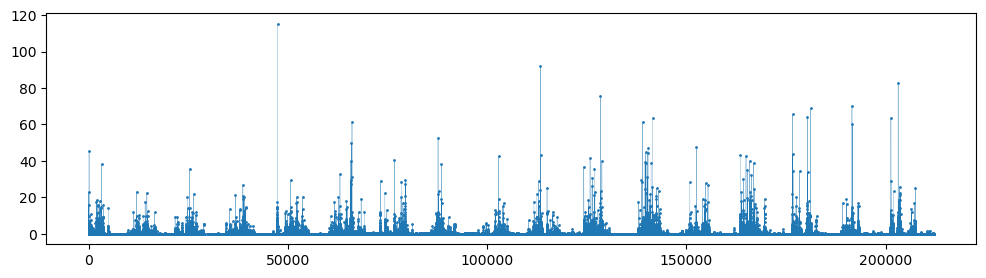

In [58]:
ds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
    network="ASOSAWOS", station="ASOSAWOS_74505823277"
)
df.pr.plot(figsize=(12, 3), x="time", y="pr", marker=".", lw=0.2, ms=2)

<AxesSubplot:xlabel='time'>

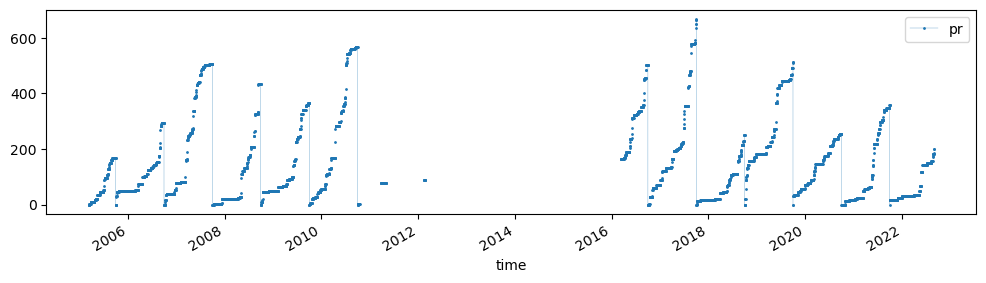

In [60]:
ds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
    network="ASOSAWOS", station="SCAN_2104"
)
df.plot(figsize=(12, 3), x="time", y="pr", marker=".", lw=0.2, ms=2)

<AxesSubplot:xlabel='time'>

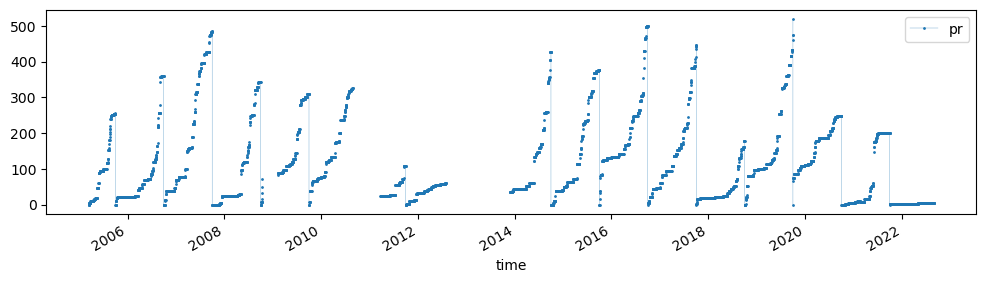

In [34]:
ds, df, MultiIndex, attrs, var_attrs, era_qc_vars = read_testing_file(
    network="ASOSAWOS", station="SCAN_2107"
)
df.plot(figsize=(12, 3), x="time", y="pr", marker=".", lw=0.2, ms=2)

<AxesSubplot:>

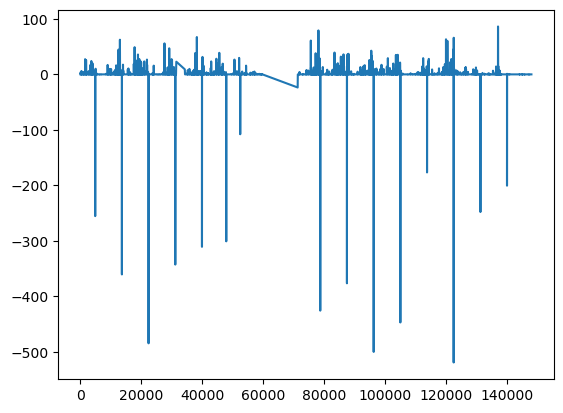

In [55]:
df.pr.dropna().diff().plot()

(-30.0, 90.0)

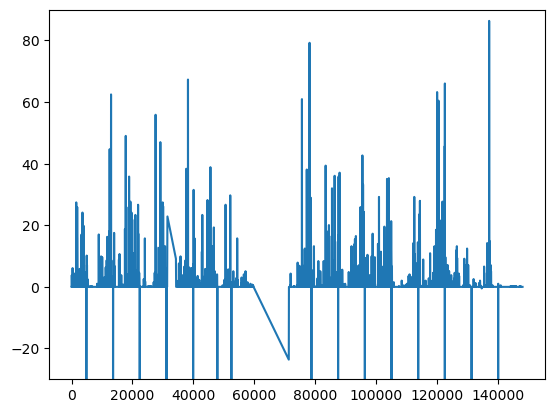

In [62]:
df.pr.dropna().diff().plot()
plt.ylim(-30, 90)

(-30.0, 90.0)

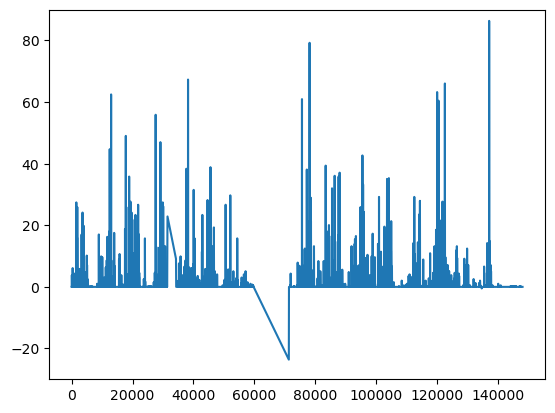

In [61]:
diffs, flag = de_accumulate(df.pr, reset_threshold=50, window=3, threshold=10)
diffs.dropna().plot()
plt.ylim(-30, 90)

In [78]:
new_df = qaqc_deaccumulate_precip(
    df, var="pr", reset_threshold=50, threshold=10, window=3
)

<AxesSubplot:>

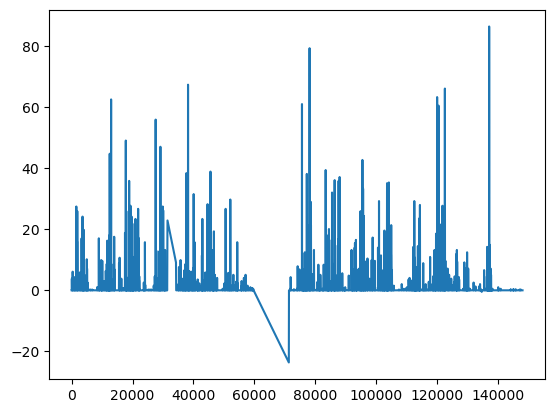

In [79]:
new_df.pr.dropna().plot()

<AxesSubplot:>

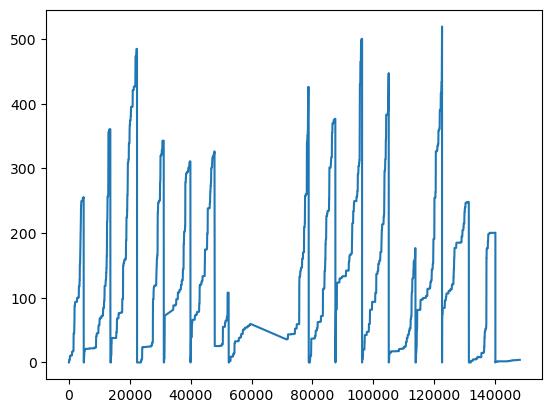

In [80]:
new_df.accum_pr.dropna().plot()

In [85]:
ds = xr.open_zarr("s3://wecc-historical-wx/3_qaqc_wx/RAWS/RAWS_BATN2.zarr")
dum = qaqc_ds_to_df(ds)
df = dum[0]

<AxesSubplot:xlabel='time'>

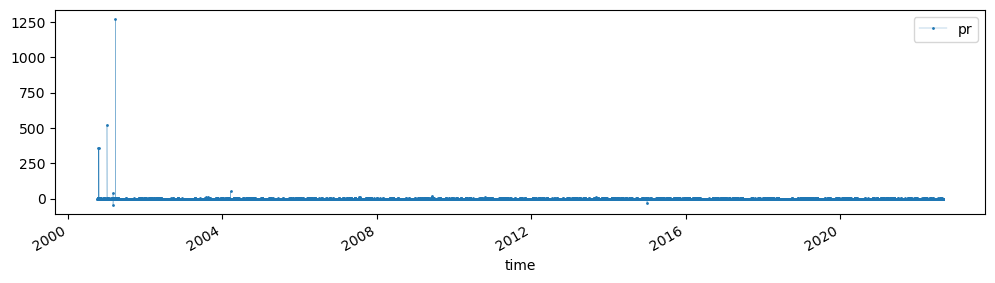

In [86]:
df.plot(figsize=(12, 3), x="time", y="pr", marker=".", lw=0.2, ms=2)

<AxesSubplot:xlabel='time'>

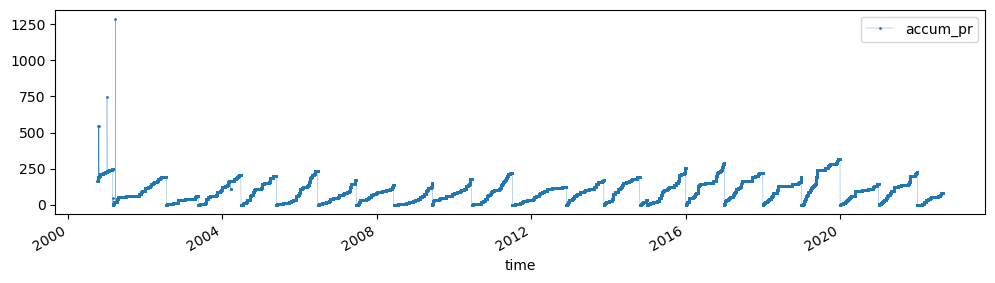

In [87]:
df.plot(figsize=(12, 3), x="time", y="accum_pr", marker=".", lw=0.2, ms=2)